---
layout: post
title: Sprint5 Blog
description:  Leaderboard
type: issues 
comments: true
---

Group
The purpose of our group’s program is to create a multiplayer drawing and guessing game inspired by Scribble.io. This program allows players to take turns drawing while others guess the word or phrase being illustrated. The goal is to provide an entertaining and interactive way for people to engage in creative gameplay, fostering collaboration, quick thinking, and creativity.

Individual
My individual feature is primarily focused on making a leaderboard to showcase your scores. This feature allows people to see their highscores, low scores, and challenge themselves with default scores to earn a better score. The purpose of the feature is to also allow for a more gamelike experience for players.



## Fullstack


# Leaderboard API Technical Analysis

## 1. List Requests, Use of Lists, Dictionaries, and Database




### List Requests
- The `GET` method retrieves all leaderboard entries and returns them as a JSON response.

### Use of Lists and Dictionaries
- The `entries` variable is a list of `LeaderboardEntry` objects, and each entry is converted to a dictionary format for the JSON response.

### Formatting Response Data
- The API formats the results as a list of dictionaries, where each row in the database represents a list entry, and each column is stored as key-value pairs in a dictionary.

### Database Queries
- SQLAlchemy is used to query the database, returning Python lists representing rows of data.

### Methods in Class
- The `_CRUD` class within `LeaderboardAPI` defines methods to create, read, update, and delete entries, working with the columns of the database.

### Algorithmic Code Request
- The API class and methods are defined to handle different types of HTTP requests (`GET`, `POST`, `DELETE`). Each method in the class corresponds to a specific CRUD operation.



In [ ]:
from flask import Blueprint, request, g
from flask_restful import Api, Resource
from datetime import datetime
from __init__ import app
from api.jwt_authorize import token_required
from model.leaderboard import LeaderboardEntry
from model.competition import Time

# Create Blueprint for API routing
leaderboard_api = Blueprint('leaderboard_api', __name__, url_prefix='/api')
api = Api(leaderboard_api)

class LeaderboardAPI:
    class _CRUD(Resource):
        @token_required()  # Require authentication
        def post(self):
            """Create or update a leaderboard entry"""
            # Get current authenticated user
            current_user = g.current_user
            data = request.get_json()

            # Validate request data
            if not data or "drawing_name" not in data:
                return {
                    "message": "Missing drawing name",
                    "error": "Bad Request"
                }, 400

            try:
                if "score" in data:
                    # Manual score input
                    score = int(data['score'])
                else:
                    # Get competition data for automatic score calculation
                    competition_entry = Time.query.filter_by(
                        created_by=current_user.id,
                        drawn_word=data['drawing_name']
                    ).first()

                    if not competition_entry:
                        return {
                            "message": "No competition entry found for this drawing",
                            "error": "Not Found"
                        }, 404

                    # Calculate speed factor and scale to 1000 points
                    speed_factor = competition_entry.timer_duration / competition_entry.time_taken
                    score = min(1000, int(speed_factor * 500))

                # Check if entry exists and update if necessary
                existing_entry = LeaderboardEntry.query.filter_by(
                    created_by=current_user.id,
                    drawing_name=data['drawing_name']
                ).first()

                if existing_entry:
                    if score > existing_entry.score:
                        existing_entry.score = score
                        existing_entry.update()
                    return existing_entry.read(), 200
                else:
                    entry = LeaderboardEntry(
                        profile_name=current_user.name,
                        drawing_name=data['drawing_name'],
                        score=score,
                        created_by=current_user.id
                    )
                    entry.create()
                    return entry.read(), 201

            except Exception as e:
                return {
                    "message": "Failed to create/update entry",
                    "error": str(e)
                }, 500

        def get(self):
            """Get leaderboard entries with calculated scores from competition data"""
            try:
                # Track deleted entries to prevent re-adding
                deleted_entries = set()
                competition_entries = Time.query.all()
                print(f"Found {len(competition_entries)} competition entries")
                result = {}

                for entry in competition_entries:
                    word = entry.drawn_word
                    if word not in result:
                        result[word] = []
                        print(f"Processing word: {word}")

                    # Skip if this entry was previously deleted from leaderboard
                    entry_key = f"{entry.created_by}_{word}"
                    if entry_key in deleted_entries:
                        continue

                    # Calculate speed factor: original_time/actual_time
                    speed_factor = entry.timer_duration / entry.time_taken
                    score = min(1000, int(speed_factor * 500))
                    print(f"Speed factor for {entry.users_name}: {speed_factor:.2f}, Score: {score}")

                    # Create or update leaderboard entry
                    leaderboard_entry = LeaderboardEntry.query.filter_by(
                        created_by=entry.created_by,
                        drawing_name=word
                    ).first()

                    if leaderboard_entry and not leaderboard_entry.is_deleted:
                        if score > leaderboard_entry.score:
                            leaderboard_entry.score = score
                            leaderboard_entry.update()
                        result[word].append(leaderboard_entry.read())
                    elif not leaderboard_entry:
                        leaderboard_entry = LeaderboardEntry(
                            profile_name=entry.users_name,
                            drawing_name=word,
                            score=score,
                            created_by=entry.created_by,
                            is_deleted=False
                        )
                        leaderboard_entry.create()
                        result[word].append(leaderboard_entry.read())

                # Sort each word's entries by score
                for word in result:
                    result[word] = sorted(
                        result[word],
                        key=lambda x: x['score'],
                        reverse=True
                    )

                return result

            except Exception as e:
                print(f"Error in get method: {str(e)}")
                return {}

        @token_required()  # Require authentication
        def delete(self):
            """Delete a leaderboard entry (Admin only)"""
            current_user = g.current_user
            
            # Check admin role
            if current_user.role != 'Admin':
                return {
                    "message": "Admin access required",
                    "error": "Forbidden"
                }, 403

            # Validate request data
            data = request.get_json()
            if not data or "id" not in data:
                return {
                    "message": "Missing entry ID",
                    "error": "Bad Request"
                }, 400

            try:
                # Find and delete entry
                entry = LeaderboardEntry.query.get(data['id'])
                if not entry:
                    return {
                        "message": "Entry not found", 
                        "error": "Not Found"
                    }, 404

                # Mark as deleted instead of actually deleting
                entry.is_deleted = True
                entry.update()
                
                return {
                    "message": "Entry deleted successfully"
                }, 200

            except Exception as e:
                return {
                    "message": "Failed to delete entry",
                    "error": str(e)
                }, 500

    # Register CRUD endpoints
    api.add_resource(_CRUD, '/leaderboard')

## 2. Parameters and Return Type
The body of the request contains JSON data with the following fields:

- profile_name: User's Id
- drawing_name: The name of the drawing.
- score: The score achieved.

#### Example:

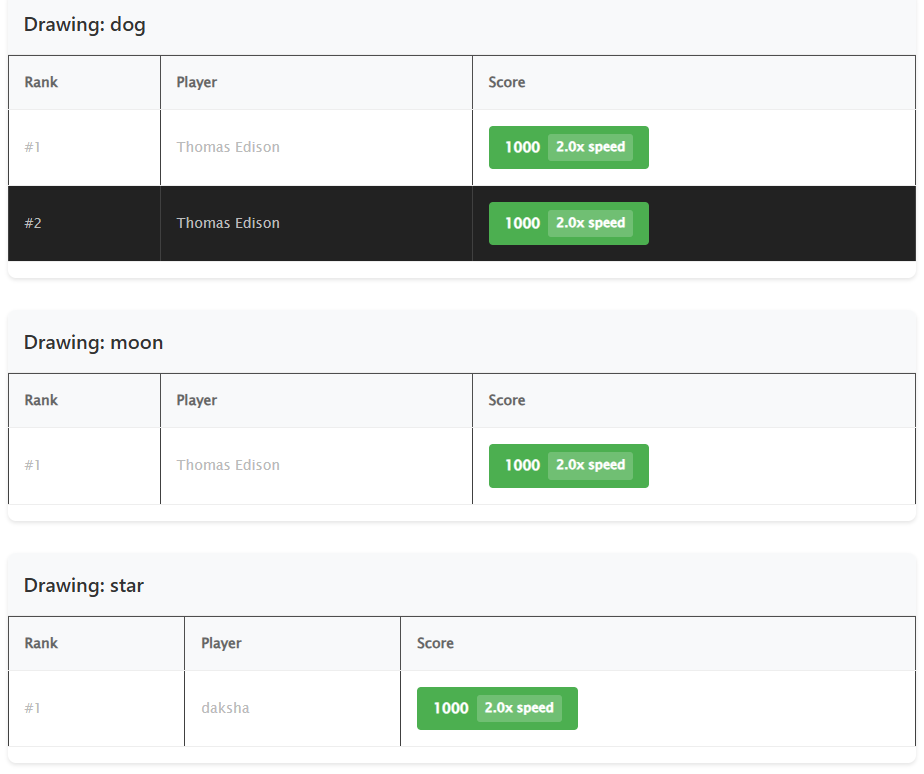

In [ ]:
#  JSON payload (real)
{
    "star": [
        {
            "id": 1,
            "profile_name": "Thomas Edison",
            "drawing_name": "star",
            "score": 1000,
            "created_by": 1,
            "is_deleted": false,
            "date_created": "2025-03-02 14:24:52",
            "date_modified": "2025-03-02 14:24:52"
        }
    ]
}

## 4. Call to Algorithm Request

### Call/Request to the Method
- The `fetchLeaderboard` function sends a `GET` request to the API endpoint to fetch leaderboard data.

### Return/Response from the Method
- The response is parsed as JSON and processed to update the DOM. Errors are logged and displayed in the DOM.

### Handling Normal and Error Conditions
- The `submitScore` and `deleteEntry` functions handle changing data and trigger different responses based on normal and error conditions, updating the DOM accordingly.


#### Call/Request to the Method:

In [ ]:
async function fetchLeaderboard() {
    try {
        // Send GET request to API endpoint to fetch leaderboard data
        const response = await fetch(`${pythonURI}/api/leaderboard`, {
            credentials: 'include'
        });

        // Check for failed response
        if (!response.ok) throw new Error('Failed to fetch leaderboard data');
        
        // Return/Response from the Method
        // Parse JSON response data
        const data = await response.json();
        const container = document.getElementById('leaderboard-sections');
        container.innerHTML = '';

        // Process and display the data in the DOM
        Object.entries(data).forEach(([word, entries]) => {
            container.appendChild(createWordSection(word, entries));
        });
    } catch (error) {
        // Log error and display error message in DOM
        console.error('Error:', error);
        showMessage(error.message, 'error');
    }
}

#### Handling Normal and Error Conditions

In [ ]:
document.getElementById('score-form').addEventListener('submit', async function(event) {
    event.preventDefault();
    const drawingName = document.getElementById('drawingName').value.trim();
    const score = document.getElementById('score').value;
    
    try {
        const body = { drawing_name: drawingName };
        if (score) {
            const scoreNum = parseInt(score);
            if (scoreNum < 0 || scoreNum > 1000) {
                showMessage('Score must be between 0 and 1000', 'error');
                return;
            }
            body.score = scoreNum;
        }

        // Send POST request to API endpoint to submit score
        const response = await fetch(`${pythonURI}/api/leaderboard`, {
            method: 'POST',
            credentials: 'include',
            headers: { 'Content-Type': 'application/json' },
            body: JSON.stringify(body)
        });

        // Parse JSON response data
        const data = await response.json();
        
        if (!response.ok) throw new Error(data.message);
        
        // Normal Condition: Success handling
        showMessage('Score submitted successfully!', 'success');
        this.reset();
        await fetchLeaderboard();
    } catch (error) {
        // Error Condition: Error handling
        console.error('Error:', error);
        showMessage(error.message, 'error');
    }
});

window.deleteEntry = async function(id) {
    if (!isAdmin) {
        showMessage('Admin access required', 'error');
        return;
    }

    if (!confirm('Are you sure you want to delete this entry?')) return;
    
    try {
        // Send DELETE request to API endpoint to delete entry
        const response = await fetch(`${pythonURI}/api/leaderboard`, {
            method: 'DELETE',
            credentials: 'include',
            headers: { 'Content-Type': 'application/json' },
            body: JSON.stringify({ id })
        });

        // Parse JSON response data
        const data = await response.json();
        
        if (!response.ok) throw new Error(data.message);
        
        // Normal Condition: Success handling
        showMessage('Entry deleted successfully', 'success');
        await fetchLeaderboard();
    } catch (error) {
        // Error Condition: Error handling
        console.error('Error:', error);
        showMessage(error.message, 'error');
    }
};